In [2]:
# @title Quickstart for Google Colab
from pathlib import Path
if Path.cwd().name != 'W5_ex':
  !git clone --quiet https://github.com/Zador-Pataki/viscomp2024/
  %cd viscomp2024/Exercises/W5

fatal: destination path 'viscomp2024' already exists and is not an empty directory.


/home/r4yl0/ETH/Vis-Comp/viscomp2024/Exercises/W5/viscomp2024/Exercises/W5


/home/r4yl0/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Week 5: PCA

The exercise of this week is about PCA. Run this notebook on Colab [following this link](https://colab.research.google.com/github/tavisualcomputing/viscomp2023/blob/main/Exercises/W5/W5_exercise.ipynb).

First load the following libraries that will be necessary and extract the dataset archive:

In [3]:
!pip install scipy
!pip install scikit-image
!pip install matplotlib
!unzip -q ./dataset.zip

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
fish: Unknown command: unzip
fish: 
unzip -q ./dataset.zip
^


In [1]:
%matplotlib inline
from skimage.io import imread
from scipy import signal,ndimage
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow,show,figure
import skimage.transform as tf
import IPython
import scipy
from sys import getsizeof

def make_grid(image_list,rows=5):
    cols = len(image_list)//rows
    row_image_list = []
    for c in range(cols):
        col_image_list = []
        for r in range(rows):
            col_image_list.append(image_list[c*rows+r])
        col_image = np.concatenate(col_image_list,axis=0)
        row_image_list.append(col_image)
    return np.concatenate(row_image_list,axis=1)

# Load images

We use the AT&T dataset, which consists of 40 people with 10 experssions each. We split the dataset into two parts, training images and test images. The training images will be used to extract the eigenfaces, which are then used to compress test images.

**First, we load the training data.** Here we take 5 expressions of 20 people as training set. 

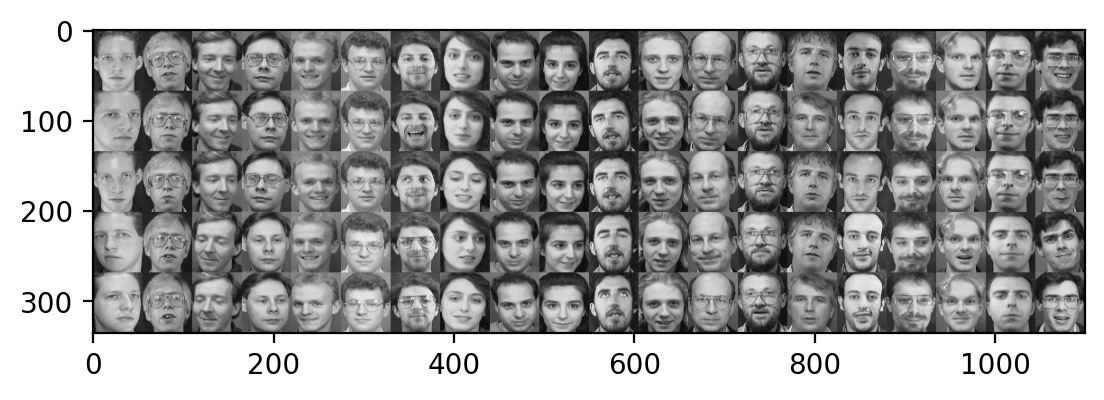

In [2]:
train_person_ids = np.arange(1,21)
train_expression_ids = np.arange(1,6)
train_image_list = []
for pid in train_person_ids:
    for eid in train_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        train_image_list.append(image)

train_image_collage = make_grid(train_image_list,rows=5)
figure(dpi=200)
imshow(train_image_collage,cmap='gray');

**Then we load the test images.** To see if the method can deal with unseen people and unseen expressions, we test with the rest 5 expressions of the rest 20 people.

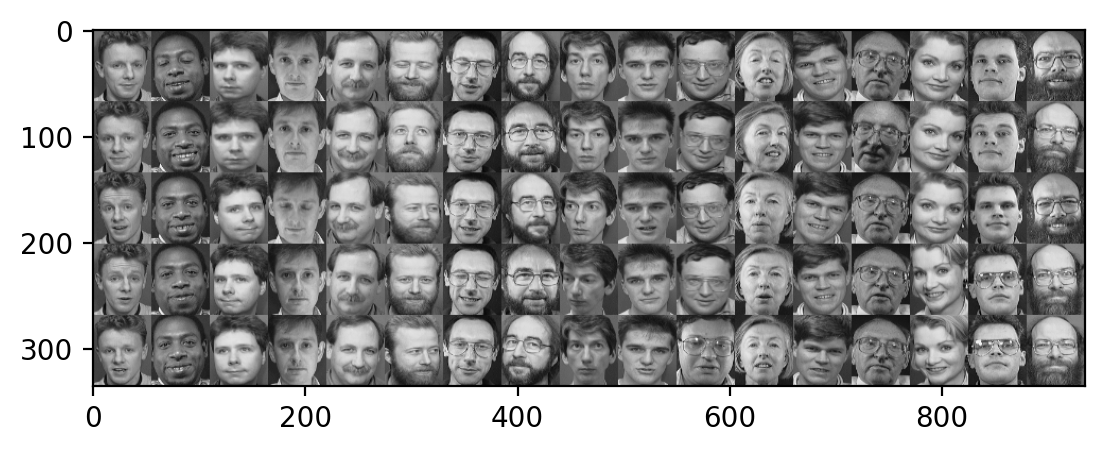

In [3]:
test_person_ids = np.arange(21,38)
test_expression_ids = np.arange(6,11)
test_image_list = []
for pid in test_person_ids:
    for eid in test_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        test_image_list.append(image)
        
test_image_collage = make_grid(test_image_list,rows=5)
figure(dpi=200)
imshow(test_image_collage,cmap='gray');

## Part A: Image Compression

In part A, we will use PCA to compress face images. For convenience we reshape the N training images into vectors of length $D = Height\times Width$ and concatenate all vectors to form a $D \times N$ matrix $X$.

In [4]:
image_vectors = [image.flatten() for image in train_image_list]
X = np.stack(image_vectors, axis=1)

**Compute the mean and covariance of images.** The mean of images $\mu$ is a vector of length $D$ and can be visualized as an image. The covariance $\Sigma$ is a $D \times D$ matrix. You can use `numpy.mean()` and `numpy.cov()` for the computation.

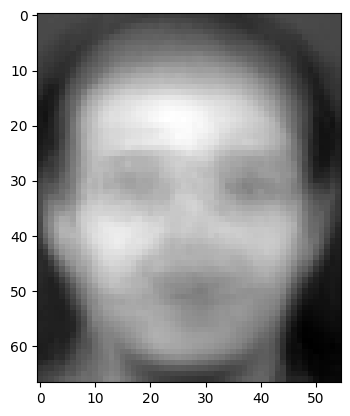

In [64]:
mean = np.array([np.mean([X[y,x] for x in range(20*5)]) for y in range(h*w)])# Your lines here. Compute the mean.: X.mean(1)
covariance = np.array(np.cov(X)) # Your lines here. Compute the covariance.: np.cov(X)

imshow(mean.reshape(h,w),cmap='gray')

**Compute eigenfaces.** Eigenfaces are the eigenvectors correponding to k-largest eigenvalues of covariance matrix. You can use `scipy.sparse.linalg.eigs(mat,k)` to compute $k$ largest eigenvalues of $mat$ and corresponding eigenvectors $[u_1 ... u_k]$ . Note that this function returns complex valued results, which needs to be converted to real numbers using `numpy.real()`.

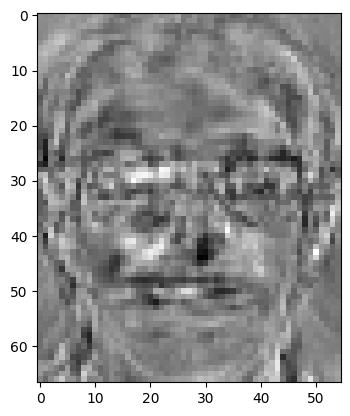

In [76]:
num_eigenvectors = 50
eigenvectors = scipy.sparse.linalg.eigs(covariance, num_eigenvectors)[1].real # Your lines here. Compute the eigenfaces.

for eigenvector in eigenvectors.T:
    imshow(eigenvector.reshape(h,w),cmap='gray')    
    IPython.display.clear_output(True)
    show()

**Now we can use the computed eigenfaces to compress images.** Face images can be approximated by linear combinations of eigenfaces $x=\mu + c_1 u_1 + c_2 u_2 + .... + c_k u_k$. Therefore, we can use the weights $[c_1 ... c_k]$ to record a image, instead of saving all pixels values. Each weight $c_i$ is the projection of the normalized image $\tilde{x} = x-\mu$ onto the corresponding eigenface $u_i$, which can be computed by dot product $c_i = \tilde{x} \cdot u_i$. 

To recover a image from its compression we can use  $x=\mu + c_1 u_1 + c_2 u_2 + .... + c_k u_k$.


**Complete the lines below to compress a image into a $k$ dimensional vector.**

**Q:** Compress training images and test images. On which set the method works better? Why?

**Q:** Compress image with different number of eigenfaces. What's the influence of $k$?

**Q:** Considering that we want to reduce data size, what is the maximum value of $k$?

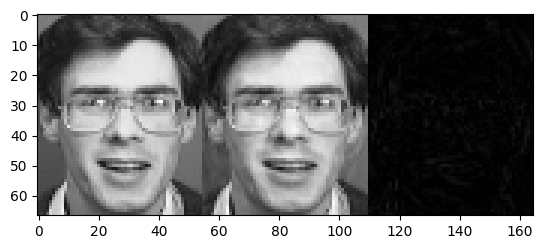

Size before compression: 29480 Bytes
Size after compression: 400 Bytes
4.948600821220038


In [97]:
error_images = []
for image in train_image_list[:]:
    
    centered_image = image.flatten() - mean;
    compressed_image =eigenvectors.T @ centered_image
    # Your lines here. Compress the image into a vector of lenght k. 
    #[c1, ..., ck]
    # [(image-mean)*eigenvectors[i] for i in range(num_eigenvectors)]
    
    
    centered_image = eigenvectors @ compressed_image
    decompressed_image = centered_image + mean
    # Your lines here. Decompress the image.
    
    error_image = np.abs(decompressed_image-image.flatten())
    error_images.append(error_image)

    imshow(np.concatenate([image.reshape(h,w),\
                          decompressed_image.reshape(h,w),\
                          error_image.reshape(h,w)],axis=-1),cmap='gray')

    IPython.display.clear_output(True)
    show()
    
print('Size before compression: %d Bytes'%image.nbytes)
print('Size after compression: %d Bytes'%compressed_image.nbytes)
           
error_images = np.stack(error_images,0)
ssd_error = (error_images**2).sum(-1).mean()
print(ssd_error)

# Part B: Face Detection with PCA
**In this part we will use PCA to detect faces.** In previous part, we have implemented a compressor for face images. Since the eigenvectors are extracted from faces images, we can expect that such a compressor would fail on other images, leading to erroneous decompression. This fact can be used for face detection.

You are given an image with a face and your task is to find the location (x coordinate) of the face.
Try to compress and then decompress each part of the image using the method in part A, and then compute the SSD error. Based on the SSD error, find the localtion (x coordinate) where the face is located.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = imread('FaceDetection.bmp')[:h,:]/255.
h_,w_ = image.shape

errors = []

# iterate over each part of the image
for x in range(w_-w):
    image_crop = image[:,x:x+w].flatten()

    centered_image = image.flatten() - mean;
    compressed_image =eigenvectors.T @ centered_image
    
    
    centered_image = eigenvectors @ compressed_image
    decompressed_image = centered_image + mean

    error = # Your lines here. Compress and decompress the image patch and compute the reconstruction error.
    
    errors.append(error)
    
    fig, ax = plt.subplots(2,1)
    rect = patches.Rectangle((x,0),w,h,linewidth=3,edgecolor='r',facecolor='none')
    ax[0].imshow(image,cmap='gray')
    ax[0].add_patch(rect)
    ax[1].plot(np.arange(x+1)+w//2,np.array(errors))
    ax[1].set_xlim([0,w_])
    IPython.display.clear_output(True)
    show()

x_best = np.argmin(errors)
fig, ax = plt.subplots(2,1)
rect = patches.Rectangle((x_best,0),w,h,linewidth=3,edgecolor='g',facecolor='none')

ax[0].imshow(image,cmap='gray')
ax[0].add_patch(rect)
ax[1].plot(np.arange(x+1)+w//2,np.array(errors))
ax[1].set_xlim([0,w_])
IPython.display.clear_output(True)
show()

# Part C: Exam question

![alt](exam_question.png)